In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import random
import torch
import os
import numpy as np
from torchvision.datasets import MNIST, SVHN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
from torch.utils.data import Dataset
from sklearn.svm import LinearSVC

# from datasets import getPairedDataset
from model import EncoderA, EncoderB, DecoderA, DecoderB
from classifier import MNIST_Classifier, SVHN_Classifier
from util import unpack_data, apply_poe


from copy import deepcopy

import sys

sys.path.append("../")
import probtorch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data =  np.load(r"C:\Users\Harris_Lab\Projects\SPLICE\data\mnist\mnist_rotated_360.npz")

X = torch.Tensor(data["original"][:50000]).to(device).reshape(-1, 1, 28, 28)
Y = torch.Tensor(data["rotated"][:50000]).to(device).reshape(-1, 1, 28, 28)

X_val = (
    torch.Tensor(data["original"][50000:60000]).to(device).reshape(-1, 1, 28, 28)
)

Y_val = torch.Tensor(data["rotated"][50000:60000]).to(device).reshape(-1, 1, 28, 28)

X_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)
angles_test = data["angles"][60000:]
labels_test = data["labels"][60000:]

In [3]:
class ViewDataset(Dataset):
    def __init__(self, v1, v2):
        self.v1 = torch.tensor(v1).float()
        self.v2 = torch.tensor(v2).float()
        self.data_len = v1.shape[0]

    def __getitem__(self, index):
        return self.v1[index], self.v2[index], index

    def __len__(self):
        return self.data_len

In [6]:
batch_size = 100
dataset = ViewDataset(X[:50000], Y[:50000])
val_dataset = ViewDataset(X_test, Y_test)

train_loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)

C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_25944\650383694.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v1 = torch.tensor(v1).float()
C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_25944\650383694.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v2 = torch.tensor(v2).float()


### True Private dimensionality

In [38]:
dims = [2,3,5,7,10]
n_shared = 30
n_privateA = 0
wseed = 0

top2_var = np.zeros(5)

for dim in dims:
    print("dim: ", dim)
    n_privateB = dim

    encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
    decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

    decA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decA.rar") % dim))
    encA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encA.rar") % dim))
    encB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encB.rar") % dim))
    decB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decB.rar") % dim))

    # encode
    q = encA(X_test, num_samples=1) 
    q = encB(Y_test, num_samples=1, q=q)    

    mu_poe, std_poe = apply_poe(
                    True,
                    q["sharedA"].dist.loc,
                    q["sharedA"].dist.scale,
                    q["sharedB"].dist.loc,
                    q["sharedB"].dist.scale,
                )
    q.normal(mu_poe, std_poe, name="poe")

    private = q["privateB"].dist.loc.squeeze(0).detach().cpu().numpy()

    pca = PCA(n_components=dim)
    pca.fit(private)

    # plt.figure()
    # plt.plot(np.arange(dim)+1, np.cumsum(pca.explained_variance_ratio_), marker='o')
    # plt.xlim(0, 10); plt.ylim(0, 1)

    # print(np.cumsum(pca.explained_variance_ratio_)[1])
    # print(dims.index(dim))

    top2_var[dims.index(dim)] = np.cumsum(pca.explained_variance_ratio_)[1]

dim:  2
dim:  3
dim:  5
dim:  7
dim:  10


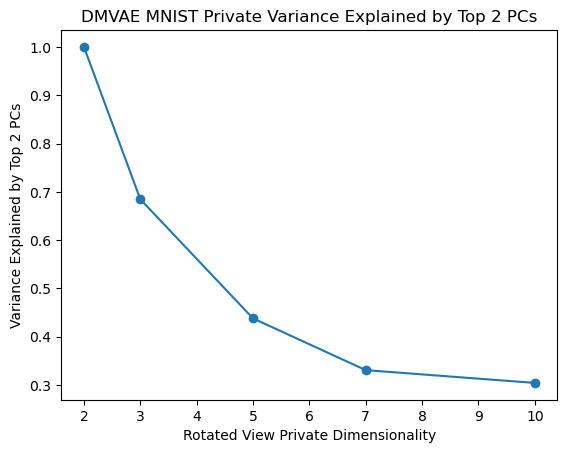

In [39]:
plt.plot(dims, top2_var, marker='o');
plt.title("DMVAE MNIST Private Variance Explained by Top 2 PCs")
plt.ylabel('Variance Explained by Top 2 PCs')
plt.xlabel('Rotated View Private Dimensionality')

plt.savefig("../../figures/jmlr/DMVAE_MNIST_extra_dims_top2pc.svg", transparent=True, dpi=300)

### Cross reconstructions

In [41]:
def rot_digit(m, angle=-1):
    """
    Returns the digit/image "m" by a random angle [-45,45]deg
    clips it to MNIST size
    and returns it flattened into (28*28,) shape
    """
    if angle < 0:
        angle=np.random.rand()*360 #will lead to ambiguities because "6" = "9"

    m = m.reshape((28,28))
    tmp = rotate(m, angle=angle)
    xs, ys = tmp.shape
    xs = int(xs/2)
    ys = int(ys/2)
    rot_m = tmp[xs-14:xs+14,ys-14:ys+14]
    return rot_m.reshape((28*28,)), angle

In [42]:
dims = [2,3,5,7,10]
n_shared = 30
n_privateA = 0
wseed = 0

top2_var = np.zeros(5)

#digit and angle sources
digit_source = torch.Tensor(np.tile(data["original"][-10000:][2463].reshape(-1,1,28,28), [5,1,1,1])).to(device)
rot_angles = [36, 108, 180, 252, 324]
rot_inds = [264, 3910, 2463, 4756, 7293]
angle_sources = np.zeros((5,784))

for i, angle in enumerate(rot_angles):
    angle_sources[i] = rot_digit(data["original"][-10000:][rot_inds[i]], angle=angle)[0]
angle_sources = torch.Tensor(angle_sources).reshape(-1,1,28,28).to(device)


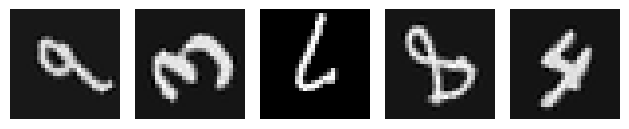

In [43]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(angle_sources[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray")
    # plt.savefig(f"../../figures/arxiv_figures/Lee_cross_rec_{i}.png", transparent=True, dpi=300)
    plt.axis("off");

plt.tight_layout()


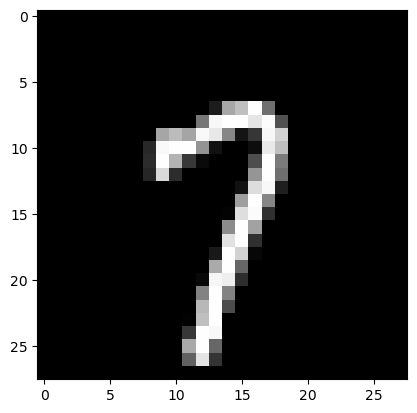

In [44]:
plt.imshow(data["original"][-10000:][2463].reshape(28,28), cmap="gray")

dim:  2
dim:  3
dim:  5
dim:  7
dim:  10


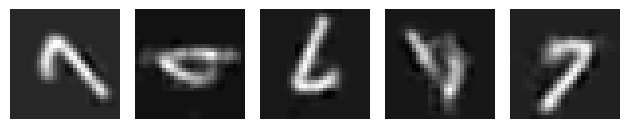

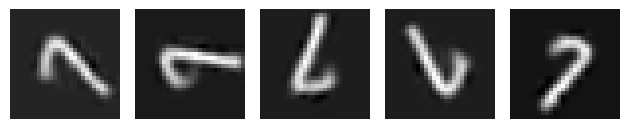

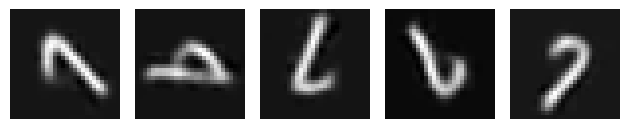

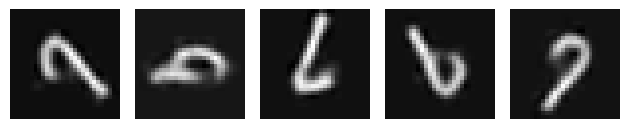

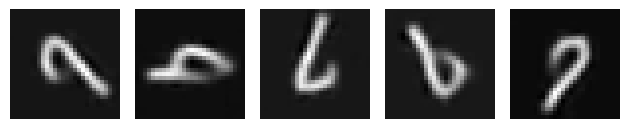

In [45]:
for dim in dims:
    print("dim: ", dim)
    n_privateB = dim

    encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
    decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

    decA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decA.rar") % dim))
    encA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encA.rar") % dim))
    encB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encB.rar") % dim))
    decB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decB.rar") % dim))

    q = encA(digit_source, num_samples=1)
    q = encB(angle_sources, num_samples=1, q=q)
    shared_cross = q["sharedA"].dist.loc.squeeze(0)
    private_cross = q["privateB"].dist.loc.squeeze(0)

    cross_rec = decB.forward2(torch.cat((private_cross, shared_cross), dim=-1))

    plt.figure()
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(cross_rec[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray")
        plt.axis("off");

    plt.tight_layout()
    plt.savefig("../../figures/jmlr/Lee_%ddim_cross_rec.svg" % (dim), transparent=True, dpi=300)



### SVM for digit identity on privates

In [25]:
dims = [2,3,5,7,10]
private_svm_acc = np.zeros(5)
chance_svm_acc = np.zeros((5,500))

for dim in dims:
    print("dim: ", dim)
    n_privateB = dim

    encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
    decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

    decA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decA.rar") % dim))
    encA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encA.rar") % dim))
    encB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encB.rar") % dim))
    decB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decB.rar") % dim))

    private = []
    for i, batch in enumerate(train_loader):
        if batch[0].size()[0] == batch_size:
            images1 = batch[0]
            images2 = batch[1]

            # encode
            # print(images.sum())
            q = encA(images1, num_samples=1)
            q = encB(images2, num_samples=1, q=q)

            privateB = q["privateB"].dist.loc

            private.append(privateB.detach().cpu().numpy().squeeze())
    private = np.concatenate(private, axis=0)
    
    private_test = []

    for i, batch in enumerate(test_loader):
        if batch[0].size()[0] == batch_size:
            images1 = batch[0]
            images2 = batch[1]

            # encode
            # print(images.sum())
            q = encA(images1, num_samples=1)
            q = encB(images2, num_samples=1, q=q)

            privateB = q["privateB"].dist.loc

            private_test.append(privateB.detach().cpu().numpy().squeeze())
    private_test = np.concatenate(private_test, axis=0)


    svm = LinearSVC(max_iter=10000)
    svm.fit(private[:20000], data["labels"][:20000].astype(int))
    private_svm_acc[dims.index(dim)] = svm.score(private_test, data["labels"][60000:].astype(int))

    # permutation test
    for i in range(500):
        print(i, end='\r')
        private = np.roll(private[:20000], 1, axis=0)
        private_test = np.roll(private_test, 1, axis=0)
        svm.fit(private, data["labels"][:20000].astype(int))
        chance_svm_acc[dims.index(dim),i] = svm.score(private_test, data["labels"][60000:].astype(int))


dim:  2
dim:  3
dim:  5
dim:  7
dim:  10


In [26]:
private_svm_acc

array([0.1116, 0.1158, 0.1198, 0.1316, 0.1401])

In [28]:
private_svm_pvals = np.zeros(5)
for i in range(5):
    private_svm_pvals[i] = (np.sum(private_svm_acc[i] < chance_svm_acc[i])) / 500

private_svm_pvals

array([0.852, 0.008, 0.   , 0.   , 0.   ])

### theta-related variance in privates

In [32]:
dims = [2,3,5,7,10]
shifts = np.load(r"C:\Users\Harris_Lab\Projects\SPLICE\results\mnist_test5k_shifts.npy")
var_explained_by_theta = np.zeros(5)

for dim in dims:
    print("dim: ", dim)
    n_privateB = dim

    encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
    encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
    decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

    decA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decA.rar") % dim))
    encA.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encA.rar") % dim))
    encB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-encB.rar") % dim))
    decB.load_state_dict(torch.load(("../weights/mnist_svhn_cont/DMVAE_%dD-decB.rar") % dim))

    private_test = []

    for i, batch in enumerate(test_loader):
        if batch[0].size()[0] == batch_size:
            images1 = batch[0]
            images2 = batch[1]

            q = encA(images1, num_samples=1)
            q = encB(images2, num_samples=1, q=q)

            privateB = q["privateB"].dist.loc

            private_test.append(privateB.detach().cpu().numpy().squeeze())
    private_test = np.concatenate(private_test, axis=0)

    window_vars = []

    shifted_angles = (data["angles"][-10000:][:5000]+shifts) % 360
    full_var = np.var(private_test[:5000], axis=0)
    width = 5

    for i in range(360):
        window = private_test[:5000][(shifted_angles > i) & (shifted_angles < i+width)]
        var = np.var(window, axis=0)/full_var
        window_vars.append(var.mean())
    var_explained_by_theta[dims.index(dim)] = 1 - np.mean(window_vars)
    

dim:  2
dim:  3
dim:  5
dim:  7
dim:  10


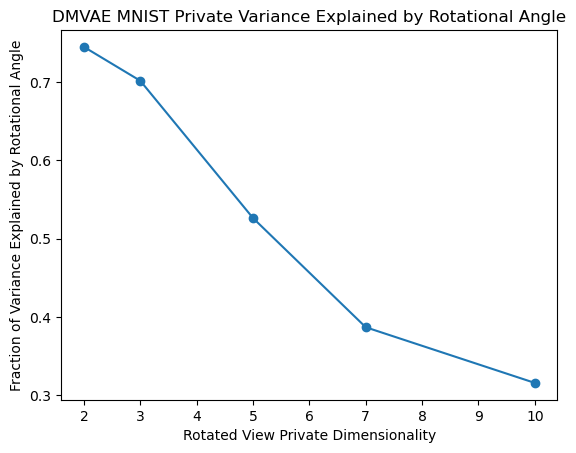

In [40]:
# USE THIS ONE

plt.plot(dims, var_explained_by_theta, marker='o');
plt.title("DMVAE MNIST Private Variance Explained by Rotational Angle")
plt.ylabel("Fraction of Variance Explained by Rotational Angle")
plt.xlabel('Rotated View Private Dimensionality')

plt.savefig("../../figures/jmlr/DMVAE_MNIST_extra_dims_theta-var-exp.svg", transparent=True, dpi=300)